[En français](../use-case_skewt-interactive_fr/)  

![ECCC logo](https://eccc-msc.github.io/open-data/img_eccc-logo.png)  

[TOC](https://eccc-msc.github.io/open-data/readme_en/) > [Usage overview](https://eccc-msc.github.io/open-data/usage/readme_en/) > WMS request in Python

# Use case: sounding graphs based on open-data

## Introduction

Weather, climate and water data from [MSC GeoMet](https://eccc-msc.github.io/open-data/msc-geomet/readme_en/) geospatial web services can be easily used to predict demand associated with certain products or services. This usage example shows how to extract and process raw sounding data with [Python](https://www.python.org/) programming language to create a tool to plot and display different data depending on the inputs provided. The interactive version is a lot more complete and user-friendly, but the code is very complex and as such the simpler example was made as a teaching tool. This use case is used to instead show observation data and is more of a tool than a real learning opportunity. However, the goal of these Notebooks is still to teach you how to:
* Access and query sounding data from MSC GeoMet geospatial web services;
* Query layers to get data for specific locations;
* Create temporal queries;
* Show results in different formats including plots and data tables.

The [simple version (this version) of this Jupyter Notebook is available here](https://mybinder.org/v2/gh/PhilippeTh/open-data/sounding-use-case?labpath=docs%2Fusage%2Fuse-case_skewt%2Fuse-case_skewt_en.ipynb).

[![badge](https://img.shields.io/badge/Simple%20version-binder-E66581.svg?logo=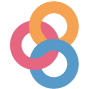)](https://mybinder.org/v2/gh/PhilippeTh/open-data/sounding-use-case?labpath=docs%2Fusage%2Fuse-case_skewt%2Fuse-case_skewt_en.ipynb)

The [interactive version of this Jupyter Notebook is available here](https://mybinder.org/v2/gh/PhilippeTh/open-data/sounding-use-case?labpath=docs%2Fusage%2Fuse-case_skewt%2Fuse-case_skewt-interactive_en.ipynb).

[![badge](https://img.shields.io/badge/Interactive%20version-binder-F5A252.svg?logo=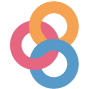)](https://mybinder.org/v2/gh/PhilippeTh/open-data/sounding-use-case?labpath=docs%2Fusage%2Fuse-case_skewt%2Fuse-case_skewt-interactive_en.ipynb)

The [observations version of this Jupyter Notebook is available here](https://mybinder.org/v2/gh/PhilippeTh/open-data/sounding-use-case?labpath=docs%2Fusage%2Fuse-case_skewt%2Fuse-case_skewt-obs_en.ipynb).

[![badge](https://img.shields.io/badge/Observations%20version-binder-579ACA.svg?logo=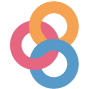)](https://mybinder.org/v2/gh/PhilippeTh/open-data/sounding-use-case?labpath=docs%2Fusage%2Fuse-case_skewt%2Fuse-case_skewt-obs_en.ipynb)

## Creation of a tool to extract and plot sounding data

Consider the following situation: Gerald, an aircraft pilot, would like to be able to access upper air observations from the Canadian data in an easily understandable and accurate manner. Considering he can be needing it at any time of the day and would like to know forecasts for an upcoming flight. A friend of his also told him there might be uneven weather on the path he's chosen, as such Gerald would like to fact-check that information for himself and see whether he needs to maybe change his course or even delay or cancel his flight. Gerald wants to be able to get the information he needs in a timely manner using the soundings forecast obtained from MSC GeoMet geospatial web services.

To be able to see the data for a specific time and place, the first step is to query the ``Extract Sounding Data Geomet OGC API Process`` from MSC to get the data associated with the provided model, model run, forecast hour and lat/lon through Python programming. To carry out this step, the Python modules must first be imported and values must be given to the request parameters. The layer used for this exemple will be the layer from the [Regional Deterministic Prediction System (RDPS)](https://eccc-msc.github.io/open-data/msc-data/nwp_rdps/readme_rdps_en/) that contains the deterministic forecasts of elements of the atmosphere from the present day to 84 hours in the future (``RDPS.ETA_TT``).

In [1]:
# Remove the magic command to use out of Jupyter Notebook
%matplotlib widget

# Importation of Python modules
import base64
import io
import logging
import math
import re
import requests

# The following modules must first be installed to use 
# this code out of Jupyter Notebook
from adjustText import adjust_text
from bs4 import BeautifulSoup
from ipywidgets import Button, Dropdown, HBox, HTML, Output
from matplotlib.font_manager import FontProperties
import matplotlib.gridspec as gridspec
import matplotlib.patheffects as mpatheffects
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# metpy throws a Cartopy warning for no reason if you don't put that even though Cartopy isn't used...
metpy_plot_logger = logging.getLogger('metpy.plots')
metpy_plot_logger.setLevel(logging.ERROR)
import metpy.calc as mpcalc
import metpy.interpolate as mpinterpolate
from metpy.plots import Hodograph, SkewT
from metpy.units import units
import pandas as pd
import PIL

The next step is to query for all available stations' csv files available.

In [2]:
# URL for all stations' data as csv files
url = 'https://dd.meteo.gc.ca/vertical_profile/observation/csv/'
resp = requests.get(url).text
soup = BeautifulSoup(resp, 'html.parser')

# Parse the HTML response and store every possible csv file
stations_filenames = [node.get('href') for node in soup.find_all('a') if node.get('href').endswith('.csv')]
stations_dict = {}
for filename in stations_filenames:

    # Split the csv file names into station ID and run hour
    filename_split = filename.split("_")
    hour = filename_split[1]
    station_id = filename_split[-1].split(".csv")[0]

    # Get the date at which each of them was run
    unformatted = soup.find("a", text=re.compile(filename)).next_sibling
    match = re.search(r'(\d+-\d+-\d+)', unformatted)

    # Store station ID with their appropriate date and time
    stations_dict[filename] = {
        'id': station_id,
        'date_time': f'{match.group(1)}T{hour}:00:00Z'
    }
# For every unique station in the list, store the ID to populate the dropdown
available_stations = list(set([station_info['id'] for station_info in stations_dict.values()]))

# Dropdown containing every unique station ID
obs_selection = Dropdown(
    layout={'width': 'initial'},
    options=available_stations,
    value=available_stations[0],
    description='Station ID: ',
    disabled=False,
)

# Dropdown to select run hour. Be careful as 12 isn't always more recent than 00.
valid_hour = Dropdown(
    layout={'width': 'initial'},
    options=['00', '12'],
    value='00',
    description='Valid Hour: ',
    disabled=False,
)

# Button to start plotting
generate_button = Button(
    description='Generate',
    disabled=False,
    button_style='',
    tooltip="Click to generate graphs from slected Obs. file",
    icon='line-chart'
)

# Put every field side by side
select_generate = HBox([obs_selection, valid_hour, generate_button])

Now that the dropdowns and options have been created, we'll create a ``class`` to read and parse the data from the slected .csv file.

In [3]:

class CSVParser:
    """
    Class to read the data inside csv files.
    """
    def __init__(self, base_url, station_id, valid_hour) -> None:
        """
        :param base_url: string -> URL where all the .csv's are.
        :param station_id: string -> 4 letters station ID.
        :param valid_hour: string -> 00 or 12
        """
        self.url = base_url
        self.station_id = station_id
        # Rebuild filename with selected options.
        filename = f'ObsTephi_{valid_hour}_{station_id}.csv'
        self.date_time = stations_dict[filename]['date_time']
        self.read_station_csv(filename)
    
    def read_station_csv(self, filename):
        self.df = pd.read_csv(f'https://dd.meteo.gc.ca/vertical_profile/observation/csv/{filename}')
        # Most files begin with a line that isn't the column names, so remeove that line
        if 'PRES' not in self.df.columns:
            self.df = pd.read_csv(f'https://dd.meteo.gc.ca/vertical_profile/observation/csv/{filename}', skiprows=[0])

    def rearrange_data(self):
        """
        Function to make sense of the data that's inside the .csv file.
        """
        # Keep only these columns.
        self.df = self.df[['PRES', 'HEIGHT', 'TEMP', 'SPRED', 'WINDDIR', 'WINDSPEED']]

        # Remove any row where there are letters.
        self.df = self.df[~self.df.PRES.str.contains("[a-zA-Z]")]

        # Remove spaces and interpret numbers as floats
        self.df.PRES = self.df['PRES'].str.replace(" ","").astype(float)

        # Keep only until the first occurence of 100hPa
        index = self.df.loc[self.df['PRES']==100].first_valid_index()
        self.df = self.df.iloc[:index]

        # Change the type of every value in other columns to float as well
        self.df = self.df.astype({'HEIGHT':'float','TEMP':'float','SPRED':'float','WINDDIR':'float','WINDSPEED':'float'})

        p = self.df['PRES'].to_list()
        h_all_vals = self.df['HEIGHT'].to_list()
        t_all_vals = self.df['TEMP'].to_list()
        td_depr_all_vals = self.df['SPRED'].to_list()
        wd_all_vals = self.df['WINDDIR'].to_list()
        ws_all_vals = self.df['WINDSPEED'].to_list()

        wd = []
        ws = []
        p_wind = []
        # Keep only wind values that make sense and their pressure level.
        for i, value in enumerate(ws_all_vals):
            if not math.isnan(value) and value != -1:
                wd.append(wd_all_vals[i])
                ws.append(ws_all_vals[i])
                p_wind.append(p[i])

        t = []
        td = []
        p_t = []
        # Keep only temperature/dewpoint values that make sense and their pressure level.
        for i, value in enumerate(t_all_vals):
            if not math.isnan(value):
                t.append(t_all_vals[i])
                td.append(t_all_vals[i] - td_depr_all_vals[i])
                p_t.append(p[i])

        self.u, self.v = mpcalc.wind_components(ws * units.knots, wd * units.degrees)
        self.t = t * units.degC
        self.td = td * units.degC
        self.ws = ws * units.knots
        self.p_t = p_t * units.hPa
        self.p_wind = p_wind * units.hPa

Now that we have the data stored, we create a class to encapsulate the graphs' creation function so they can be called whenever we want and with different arguments.

In [4]:
class SoundingGraphs(CSVParser):
    """
    Class for making the SkewT and Hodograph.
    """
    def __init__(self, base_url, station_id, valid_hour) -> None:
        """
        :param base_url: string -> URL where all the .csv's are.
        :param station_id: string -> 4 letters station ID.
        :param valid_hour: string -> 00 or 12
        """
        super().__init__(base_url, station_id, valid_hour)
        self.rearrange_data()
    
    def generate(self):
        """
        Function that creates Skew-T graph and calls Hodograph creation function.
        """
        self.fig = plt.figure(figsize=(14, 14), tight_layout=True)
        self.gs = gridspec.GridSpec(2, 1)
        skew = SkewT(self.fig, rotation=45, subplot=self.gs[0])

        # Plot the data using normal plotting functions, in this case using
        # log scaling in Y, as dictated by the typical meteorological plot.
        skew.plot(self.p_t, self.t, 'r', label='Temperature')
        skew.plot(self.p_t, self.td, 'g', label='Dewpoint')
        skew.plot_barbs(self.p_wind, self.u, self.v)
        skew.ax.set_ylim(1050, 100)
        skew.ax.set_xlim(-40, 60)
        skew.ax.xaxis.set_label_text('Temperature (°C)')
        skew.ax.yaxis.set_label_text('Pressure (hPa|mbar)')

        # Add a secondary axis that automatically converts between pressure and height
        # assuming a standard atmosphere. The value of -0.12 puts the secondary axis
        # 0.12 normalized (0 to 1) coordinates left of the original axis.
        secax = skew.ax.secondary_yaxis(
            -0.12,
            functions=(
                lambda p: mpcalc.pressure_to_height_std(units.Quantity(p, 'hPa')).m_as('km'),
                lambda h: mpcalc.height_to_pressure_std(units.Quantity(h, 'km')).m
            )
        )
        secax.yaxis.set_major_locator(plt.FixedLocator([0, 1, 3, 6, 9, 12, 15]))
        secax.yaxis.set_minor_locator(plt.NullLocator())
        secax.yaxis.set_major_formatter(plt.ScalarFormatter())
        secax.set_ylabel('Height (km)')

        # Calculate full parcel profile and add to plot as black line
        prof = mpcalc.parcel_profile(self.p_t, self.t[0], self.td[0]).to('degC')
        skew.plot(self.p_t, prof, 'k', linewidth=2, label='Parcel profile*')

        # Shade areas of CAPE and CIN
        skew.shade_cin(self.p_t, self.t, prof, self.td, label='CIN*')
        skew.shade_cape(self.p_t, self.t, prof, label='CAPE*')

        # Slanted line at 0 isotherm
        skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

        # Add the relevant special lines
        wet_bulb = mpcalc.wet_bulb_temperature(self.p_t, self.t, self.td)
        skew.plot(self.p_t, wet_bulb, 'b', linewidth=1, label='Wet Bulb*')
        skew.plot_dry_adiabats()
        skew.plot_moist_adiabats()
        skew.plot_mixing_lines()

        # Add title with all the data that was used for the plot
        skew.ax.title.set_text(f'Observation sounding at station {self.station_id} for {self.date_time}')
        skew.ax.legend()

        self.__create_hodo()

    def __create_hodo(self):
        """
        Function to create the Hodograph.
        """
        ax = self.fig.add_subplot(self.gs[1])

        # Determine the pressure level values to display on the Hodograph.
        # You may add more or remove some as you please.
        boundaries_default = [950, 850, 700, 500, 300, 250]

        # Always show first pressure level
        boundaries_p = [self.p_wind[0].magnitude]

        # Also show all the ones from the list above, but only if they're over
        # the first pressure level and are at least 50mbar over first pressure level
        # i.e. if first pressure level is at 855mbar, don't show 950 nor 850
        boundaries_p.extend([bd for bd in boundaries_default if ((boundaries_p[0]-bd)>=50 and bd>=self.p_t[-1].magnitude)])

        boundaries_p *= units.hPa
        u_pts, v_pts = mpinterpolate.interpolate_1d(boundaries_p, self.p_wind, self.u, self.v)
        boundaries_p[0] = round(boundaries_p[0])

        # Add the points on the Hodograph for the chosen pressure levels
        ax.scatter(u_pts, v_pts, c="black", zorder=10)
        texts = []
        for up, vp, z in zip(u_pts, v_pts, boundaries_p):
            z_str = int(z.magnitude)
            texts.append(ax.text(up, vp, z_str, ha='center', fontsize=10,
                         path_effects=[mpatheffects.withStroke(foreground='white', linewidth=2)],
                         zorder=12)
                        )

        # Scale hodograph according to strongest wind value
        max_range = math.ceil(max(self.ws).magnitude) + 1
        h = Hodograph(ax, component_range=max_range)

        if max_range < 50:
            inc = math.ceil(max_range / 10)
        else:
            inc = 5 * math.ceil(max_range / 100)

        # Put axes in the middle of the graph
        ax.spines['left'].set_position('zero')
        ax.spines['bottom'].set_position('zero')
        ax.patch.set_edgecolor('black')
        ax.patch.set_linewidth('0.5')

        # Add color that changes with pressure levels
        h.plot_colormapped(self.u, self.v, self.p_wind)

        # Rescale hodograph to zoom where the values are
        # Comment h.ax.autoscale() if you want the entire Hodograph instead
        h.ax.autoscale()
        bottom, top = h.ax.get_ylim()
        left, right = h.ax.get_xlim()

        # Add the grid lines for the wind speeds
        h.add_grid(increment=inc)

        # Make sure axes stay inside the plot if the winds are all super far in one direction
        if left > 0:
            left = -1
        if bottom > 0:
            bottom = -1
        if right < 0:
            right = 1
        if top < 0:
            top = 1

        # Resize the hodograph to zoom in on the plot, but only show values on the longest axis
        # and add a little buffer to make sure the entire plot always fits inside.
        norm_bottom = abs(bottom)
        norm_left = abs(left)
        whole, remainder = divmod(max_range, inc)
        highest = max(norm_bottom, top, norm_left, right)
        if highest in (norm_bottom, top):
            if highest == norm_bottom:
                norm_bottom = (whole + math.ceil(remainder/inc)) * inc
            else:
                top = (whole + math.ceil(remainder/inc)) * inc
            ax.set_ylim(bottom=-norm_bottom, top=top)
            ax.set_xlim(left=-norm_left, right=right)

            ax.yaxis.set_major_locator(mticker.MultipleLocator(inc))
            ticks_loc_y = ax.get_yticks().tolist()
            ax.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc_y))
            ax.set_yticklabels([f'{abs(int(y))}' for y in ticks_loc_y])
            ax.set_xticks([])
        else:
            if highest == norm_left:
                norm_left = (whole + math.ceil(remainder/inc)) * inc
            else:
                right = (whole + math.ceil(remainder/inc)) * inc
            ax.set_ylim(bottom=-norm_bottom, top=top)
            ax.set_xlim(left=-norm_left, right=right)

            ax.xaxis.set_major_locator(mticker.MultipleLocator(inc))
            ticks_loc_x = ax.get_xticks().tolist()
            ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc_x))
            ax.set_xticklabels([f'{abs(int(x))}' for x in ticks_loc_x])
            ax.set_yticks([])

        # Remove axes labels since the axes are in the middle of the plot
        ax.set_xlabel('')
        ax.set_ylabel('')

        h.ax.title.set_text('Hodograph, Wind Speed in knots, Height in hPa')
        
        # Make sure hodograph points' text don't overlap
        adjust_text(texts, arrowprops=dict(arrowstyle='->', color='r', lw=0.5), expand_text=(5, 5))

We now add a download button so the user may easily download the generated plot on his computer.

In [5]:
# Output widget for Download button
out_download = Output()

# This decorator makes it so download button will appear inside out_download.
@out_download.capture()
def display_download_button(img_buf, sounding_obj):
    """
    Download image using an HTML button and name the image according to provided data.

    :param img_buf: _io.BytesIO object -> Contains the image buffer the can be read
                                          and recomposed into an image.
    :param sounding_obj: SoundingGraphs object -> Used to access current plot's information.
    """
    filename = (f'Observation_sounding_{sounding_obj.station_id}_{re.sub("[-:]", "", sounding_obj.date_time)}.png')

    # Use base 64 encoding for the image buffer.
    b64 = base64.b64encode(img_buf.getvalue())
    payload = b64.decode()

    # HTML button derived from ipywidgets Button.
    # Needed so the image actually gets downloaded on the user's
    # machine and not just saved inside the Notebook's directory.
    html_button = '''<html>
                     <head>
                     <meta name="viewport" content="width=device-width, initial-scale=1">
                     </head>
                     <body>
                     <a download="{filename}" href="data:image/png;base64,{payload}" download>
                     <button class="p-Widget jupyter-widgets jupyter-button widget-button mod-warning">Download Image</button>
                     </a>
                     </body>
                     </html>
                     '''
    html_button = html_button.format(payload=payload, filename=filename)
    download_button = HTML(html_button)
    display(download_button)

We now create an event handler method that will perform actions once the generate button has been clicked.

In [6]:
# Output widget to capture graphs and prints
out = Output()

# This decorator makes it so everything that is
# displayed or printed will get put inside out.
@out.capture()
def on_generate_button_clicked(b):
    # Clear current output
    out_download.clear_output()
    # Wait until there's something new to add before clearing output.
    out.clear_output(wait=True)
    # Disbale fields and button while graphs are being generated.
    generate_button.disabled = True
    obs_selection.disabled = True
    valid_hour.disabled = True

    # Don't let matplotlib show whatever it wants.
    plt.ioff()
    # Close previous plot when making a new one.
    plt.close('all')
    try:
        obs_df = SoundingGraphs(url, obs_selection.value, valid_hour.value)
        obs_df.generate()
        img_buf = io.BytesIO()
        plt.savefig(img_buf, format='png')
        # Display figure and enable Download Button.
        display(PIL.Image.open(img_buf))
        display_download_button(img_buf, obs_df)
        img_buf.close()
    except:
        # Either the data is actually missing or the Excel sheet
        # was weirdly formatted and cannot be read.
        print("Currently unavailable or Excel Sheet not formatted properly")
    # Re-enable fields and button.
    generate_button.disabled = False
    obs_selection.disabled = False
    valid_hour.disabled = False

generate_button.on_click(on_generate_button_clicked)

Finally, we display the 2 dropdowns and the button that have been created.

In [ ]:
display(select_generate)
display(out)
display(out_download)

## Conclusion

Using this tool, Gerald will be able to compare the prediction data with the actual observation data. The example shown here is more of a complete usable tool than a learning opportunity, but hopefully this can still help you understand more how these things can be coded with Python and the all the possible things that can be achieved using it.